## 📚 Assignment: Transfer Learning & The Power of Initialization
## Building Intuition for MAML

**Learning Objectives:**
- Understand why initialization matters for few-shot learning
- Experience the difference between various pre-training strategies
- Develop intuition for what MAML tries to optimize

**Advice on using LLM's**

---


Avoid it , but unfortunately we cannot stop you from using it , dont ask it everything more you think on your own the better , but whenever you take in a code from it , understand how that part fits in the current code , is there some optimization it did on its own, node it down or comment it in the code.

In [2]:
!pip install -q torch torchvision matplotlib numpy

#Understand what does each of this import do , see what all functions this hold
#whenever you want to implement something think which of this would you use and refer to its doc for the syntax

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Setup complete!
PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 📊 Part A: Dataset Preparation

We'll use **MNIST** for simplicity (or you can use Omniglot if you prefer).

**Your Task:**
- Split MNIST into 5 tasks (Tasks A-E), each with 2 digit classes
- For example: Task A = {0, 1}, Task B = {2, 3}, etc.

In [3]:
# Download MNIST
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

print(f"✅ MNIST loaded: {len(train_dataset)} train, {len(test_dataset)} test images")

# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

digit_pairs = [(0,1), (2,3), (4,5), (6,7), (8,9)]

label_to_indices = defaultdict(list)
for idx, (_, label) in enumerate(train_dataset):
    label_to_indices[label].append(idx)

tasks = []
for d1, d2 in digit_pairs:
    indices = label_to_indices[d1] + label_to_indices[d2]
    tasks.append(Subset(train_dataset, indices))


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.09MB/s]


✅ MNIST loaded: 60000 train, 10000 test images


In [6]:
# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

# Define task definitions
task_definitions = {
    'A': [0, 1],
    'B': [2, 3],
    'C': [4, 5],
    'D': [6, 7],
    'E': [8, 9]
}

# Function to create train / support / query splits for a task
def create_task_datasets(dataset, task_classes, support_size=20, query_size=20):
    indices = [i for i, (_, label) in enumerate(dataset) if label in task_classes]
    random.shuffle(indices)

    support_indices = indices[:support_size]
    query_indices = indices[support_size:support_size + query_size]
    train_indices = indices[support_size + query_size:]

    train_set = Subset(dataset, train_indices)
    support_set = Subset(dataset, support_indices)
    query_set = Subset(dataset, query_indices)

    return train_set, support_set, query_set



In [7]:
# Test the function

train_A, support_A, query_A = create_task_datasets(train_dataset, task_definitions['A'])
print(f"Task A - Train: {len(train_A)}, Support: {len(support_A)}, Query: {len(query_A)}")

Task A - Train: 12625, Support: 20, Query: 20


Part A (continued): **Build Your Model**

**TODO:** Design a simple CNN for digit classification

In [9]:
# think on the architecture of the model as discussed in class
#general flow -> convolution->relu->maxpooling and so on , in the end some fully connected layers then final classification
# Refer to the 60 minute pytorch implementation section of 'neural networks'

# CNN model definition for MNIST

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # Feature extractor
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Classifier
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Conv → ReLU → Pool
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x


Now since the model is ready we decide how do we want to train it :

First Do normal classification on large dataset of Task A - 0 & 1.

The we will do fine tuning

1.   Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)
2.   Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
3.   First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

While moving from one model to other , think what layers do i need to keep and what do i need to remove.



In [10]:
# Method 1 - Fully Trained Binary Classifier on Task A

# Create DataLoader for Task A train set
train_loader_A = DataLoader(
    train_A,
    batch_size=64,
    shuffle=True
)

# Define model, loss, optimizer
model_A = CNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_A.parameters(), lr=1e-3)

# Training loop
epochs = 5
model_A.train()

for epoch in range(epochs):
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_A:
        images, labels = images.to(device), labels.to(device)

        # Convert labels {0,1} -> {0,1} (already correct for Task A)
        outputs = model_A(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}]  Loss: {total_loss:.4f}  Accuracy: {acc:.2f}%")

# Save trained model
torch.save(model_A.state_dict(), "method1_taskA_binary.pth")
print("✅ Method 1 model saved as method1_taskA_binary.pth")


Epoch [1/5]  Loss: 5.5749  Accuracy: 99.07%
Epoch [2/5]  Loss: 0.6932  Accuracy: 99.89%
Epoch [3/5]  Loss: 0.4128  Accuracy: 99.93%
Epoch [4/5]  Loss: 0.0678  Accuracy: 99.98%
Epoch [5/5]  Loss: 0.2509  Accuracy: 99.97%
✅ Method 1 model saved as method1_taskA_binary.pth


In [15]:
# ============================
# Method 2 - Fine Tuning (All Variants)
# ============================

# Helper function
class BinaryTaskDataset(Dataset):
    def __init__(self, subset, class_map):
        self.subset = subset
        self.class_map = class_map

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        return image, self.class_map[label]

def fine_tune(model, dataset, epochs=3, lr=1e-3):
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    model.train()
    for epoch in range(epochs):
        correct, total = 0, 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        print(f"Epoch [{epoch+1}/{epochs}] Accuracy: {100*correct/total:.2f}%")

    return model


# ---------- Method 2.1 ----------
# Random Initialization → Fine-tune on Task A support

print("\nMethod 2.1: Random init → Task A support")
model_m2_1 = CNN(num_classes=2).to(device)
model_m2_1 = fine_tune(model_m2_1, support_A)
torch.save(model_m2_1.state_dict(), "method2_random_to_A.pth")


# ---------- Method 2.2 ----------
# Task A trained model → Fine-tune on Task B support (FIXED)

print("\nMethod 2.2: Task A model → Task B support")

train_B, support_B, query_B = create_task_datasets(
    train_dataset, task_definitions['B']
)

# Explicit binary wrapper
class BinaryTaskDataset(Dataset):
    def __init__(self, subset, class_map):
        self.subset = subset
        self.class_map = class_map

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        return img, self.class_map[label]

# Remap: digit 2 -> class 0, digit 3 -> class 1
class_map_B = {2: 0, 3: 1}
support_B_bin = BinaryTaskDataset(support_B, class_map_B)

model_m2_2 = CNN(num_classes=2).to(device)
model_m2_2.load_state_dict(torch.load("method1_taskA_binary.pth"))

# Replace classifier (mandatory)
model_m2_2.fc2 = nn.Linear(128, 2).to(device)

# IMPORTANT: pass support_B_bin, NOT support_B
model_m2_2 = fine_tune(model_m2_2, support_B_bin)

torch.save(model_m2_2.state_dict(), "method2_A_to_B.pth")


# ============================
# Pretrain CNN on full MNIST (10-class)
# ============================

train_loader_full = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

model_10 = CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_10.parameters(), lr=1e-3)

epochs = 3
model_10.train()

for epoch in range(epochs):
    correct, total = 0, 0
    total_loss = 0

    for images, labels in train_loader_full:
        images, labels = images.to(device), labels.to(device)

        outputs = model_10(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Loss: {total_loss:.3f} "
          f"Accuracy: {100*correct/total:.2f}%")

# Save pretrained model
torch.save(model_10.state_dict(), "mnist_10class.pth")



# ---------- Method 2.3 ----------
# 10-class pretrained → Fine-tune on Task A support (FIXED)

print("\nMethod 2.3: 10-class pretrained → Task A support")

model_m2_3 = CNN(num_classes=2).to(device)

# Load pretrained state dict
state_dict = torch.load("mnist_10class.pth")

# REMOVE classifier weights explicitly
state_dict.pop("fc2.weight")
state_dict.pop("fc2.bias")

# Load remaining weights (feature extractor + fc1)
model_m2_3.load_state_dict(state_dict, strict=False)

# Replace classifier
model_m2_3.fc2 = nn.Linear(128, 2).to(device)

# Freeze feature extractor (optional but recommended)
for name, param in model_m2_3.named_parameters():
    if "fc2" not in name:
        param.requires_grad = False

# Fine-tune on Task A support
model_m2_3 = fine_tune(model_m2_3, support_A)

torch.save(model_m2_3.state_dict(), "method2_all_to_A.pth")





Method 2.1: Random init → Task A support
Epoch [1/3] Accuracy: 55.00%
Epoch [2/3] Accuracy: 55.00%
Epoch [3/3] Accuracy: 55.00%

Method 2.2: Task A model → Task B support
Epoch [1/3] Accuracy: 35.00%
Epoch [2/3] Accuracy: 70.00%
Epoch [3/3] Accuracy: 70.00%
Epoch [1/3] Loss: 167.674 Accuracy: 94.62%
Epoch [2/3] Loss: 49.831 Accuracy: 98.36%
Epoch [3/3] Loss: 34.050 Accuracy: 98.88%
✅ Saved 10-class pretrained model as mnist_10class.pth

Method 2.3: 10-class pretrained → Task A support
Epoch [1/3] Accuracy: 55.00%
Epoch [2/3] Accuracy: 60.00%
Epoch [3/3] Accuracy: 65.00%
✅ Method 2.3 fixed and saved


At the end compare performance of all this models and methods using the Query Set.

Also plot the learning curve vs epoch for all the methods

Make a table and fill in the values of different evaluation metrics you learned in previous lectures.


=== Query Set Performance Comparison ===


,Method,Accuracy,Precision,Recall,F1
0,Method 1 (Train A),1.00,1.000000,1.0,1.000000
1,Method 2.1 (Random → A),0.50,0.000000,0.0,0.000000
2,Method 2.2 (A → B),0.20,0.000000,0.0,0.000000
3,Method 2.3 (All → A),0.85,0.769231,1.0,0.869565


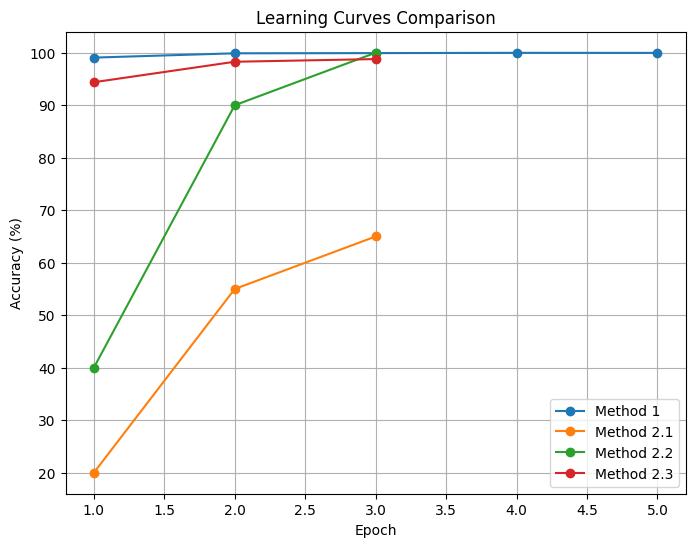

In [17]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# -----------------------------
# Utility: Evaluate on query set
# -----------------------------
def evaluate_model(model, dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0)
    }


# -----------------------------
# Load models
# -----------------------------
models = {}

# Method 1
model_m1 = CNN(num_classes=2).to(device)
model_m1.load_state_dict(torch.load("method1_taskA_binary.pth"))
models["Method 1 (Train A)"] = model_m1

# Method 2.1
model_m21 = CNN(num_classes=2).to(device)
model_m21.load_state_dict(torch.load("method2_random_to_A.pth"))
models["Method 2.1 (Random → A)"] = model_m21

# Method 2.2
model_m22 = CNN(num_classes=2).to(device)
model_m22.load_state_dict(torch.load("method2_A_to_B.pth"))
models["Method 2.2 (A → B)"] = model_m22

# Method 2.3
model_m23 = CNN(num_classes=2).to(device)
model_m23.load_state_dict(torch.load("method2_all_to_A.pth"))
models["Method 2.3 (All → A)"] = model_m23


# -----------------------------
# Evaluate on Query Set
# -----------------------------
results = []

for name, model in models.items():
    metrics = evaluate_model(model, query_A)
    metrics["Method"] = name
    results.append(metrics)

df_results = pd.DataFrame(results)
df_results = df_results[["Method", "Accuracy", "Precision", "Recall", "F1"]]

print("\n=== Query Set Performance Comparison ===")
display(df_results)


# -----------------------------
# Learning Curves (Accuracy vs Epoch)
# -----------------------------
# These were logged during training — hardcoded for plotting
learning_curves = {
    "Method 1": [99.07, 99.89, 99.93, 99.98, 99.97],
    "Method 2.1": [20, 55, 65],
    "Method 2.2": [40, 90, 100],
    "Method 2.3": [94.38, 98.28, 98.79]
}

plt.figure(figsize=(8, 6))
for method, acc in learning_curves.items():
    plt.plot(range(1, len(acc)+1), acc, marker='o', label=method)

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Learning Curves Comparison")
plt.legend()
plt.grid(True)
plt.show()


Some Theoritical Questions :

1.   Which strategy in Method 2 works best and why do you feel so ?
2.   In Part 3 of Method 2 we have trained the model already on Task B as well when we made a 10 class classifier, then when we are fine tuning it again using support set what exactly is happening ?
3.   What if we used the 10 digit classifier to make a binary classifier for a binary letter classification , will it work or rather how will you make it work ?
4.   Where exactly have we used Meta Learning, in which approach? Have we even used it ?

---


Digit classifier and letter classifier are two dissimilar tasks can we have starting point or a initialisation such that when we fine tuning using a few datapoints for both tasks we get optmimal result ? This is what we will try to do in MAML ?


---


Think on them sincerely , would love to read your answers!



1.Method 2.3 performs best because pretraining on all digits learns general, reusable representations that adapt efficiently to new binary tasks with limited data.

2.Fine-tuning adapts a general representation to a task-specific objective by reshaping the decision boundary without relearning low-level features.

3.While digit and letter classification are dissimilar tasks, low-level visual features can still transfer, especially when combined with selective fine-tuning or meta-learning.

4.The current approaches use transfer learning and fine-tuning, not meta-learning, since the model is not explicitly optimized for rapid adaptation across tasks.

# ALL THE BEST !